## Introduction

This projet implement score_based generative modeling methods on the well known FashionMNIST dataset. This notebook is inspired by [the notebook](https://colab.research.google.com/drive/120kYYBOVa1i0TD85RjlEkFjaWDxSFUx3?usp=sharing#scrollTo=GFuMaPov5HlV) of [Yang Song](https://yang-song.github.io/) who present this methods.

In this notebook you will find:
* Quick presentation of the FashionMNIST dataset
* Overview of score-based generative modeling
* Presentation and training of our scoring model
* Generation of synthetic data using differents sampling methods
* Conclusion and recall of the main differences between our notebook and the one from Yang Song


In [8]:
import torch
import numpy as np
import torch.nn as nn
import functools
from torch.optim import Adam
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import FashionMNIST
import tqdm
import torch.nn.functional as F
from scipy import integrate
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from collections import Counter


## Our Data : FashionMNIST

In [3]:
from torchvision.datasets import FashionMNIST

dataset = FashionMNIST('.', train=True, transform=transforms.ToTensor(), download=True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



In [4]:
len(dataset)

60000

In [5]:
dataset.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [13]:
classes = [label for _, label in dataset]
Counter(classes)

Counter({0: 6000,
         1: 6000,
         2: 6000,
         3: 6000,
         4: 6000,
         5: 6000,
         6: 6000,
         7: 6000,
         8: 6000,
         9: 6000})

We have a balanced dataset.

Let's look at some of its elements.

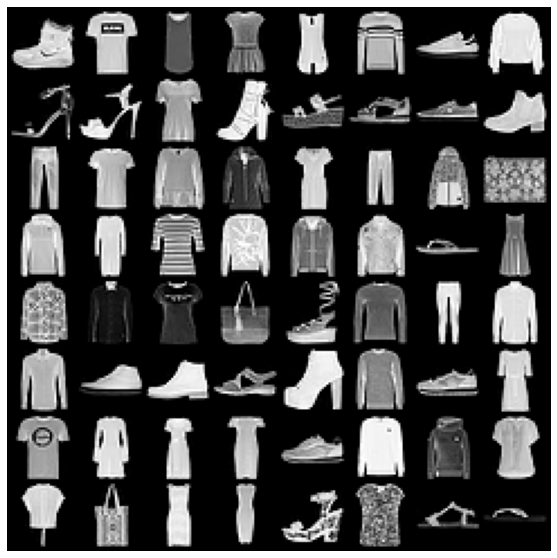

In [27]:
L = []
for i in range(64) : 
    L.append(dataset[i][0])


grid_img = make_grid(L, nrow=int(np.sqrt(64)))

plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(grid_img.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

**According to the blog:**

"*Choose the suite from $\sigma_{min}$ to $\sigma_{max}$ as a geometric progression, with $\sigma_{min}$ being sufficiently small and $\sigma_{max}$ comparable to the maximum pairwise distance between all training data points.*"


Thats why we will calculate the max distance pairwise for a sample of the data to pick our $\sigma_{max}$ .


In [3]:
sigma = 25

Let's justify our choice of $\sigma_{max} = 25$

In [6]:
from tqdm import tqdm

dist_max = 0
for i in tqdm(range(1000)) :
    for j in range(i+1, 1000) :
        dist = torch.sqrt(torch.sum((dataset[i][0]-dataset[j][0])**2)).item()
        if dist > dist_max :
            dist_max = dist

100%|██████████| 1000/1000 [03:03<00:00,  5.44it/s]


In [7]:
dist_max

20.637216567993164

We calculated the maximum distance between two images of a part of our dataset (first 1000 elements). We can see that this distance is about 20. This is why we chose to take a $\sigma_{max} = 25$, by extrapolation and security with regard to the entire dataset.

# Overview of score-based generative modeling

Goal : Generate synthetic image using the gradient of the distribution of the data.

Steps of the method:

- Training a model to approximate the gradient of the distribution To do this we use the forward SDE method, which noises the train data to
cover all the distribution an come up with beter performances. To estimate how much should we noise the data, we are looking at the
max pair wise distance on the all dataset.
- Using sampling methods based on our scoring model to transform generated noisy image (with a known distribution) into image that
respect our approximation of the data distribution.


# Our Scoring Model : U-net

The only condition on the model is that the input should be the same size than the output. The model should also be time dependend. Our data and the advice gave by Yang Song in the [blog](https://yang-song.github.io/blog/2021/score/) we will use the [U-Net](https://arxiv.org/abs/1505.04597) architecture which encode and decode images.

### The model

In [ ]:
class Time_encoder(nn.Module):
  """Encoding time using a randomized fixed parameter w and [sin(2piwt), cos(2piwt)]
  takes t as input and a vector of size embed_dim as output"""  
  def __init__(self, embed_dim, sdt=30.):
    super().__init__()
    # Requires grad is flase because this parameter is not learnable
    # this mean that w is fixed 
    # w is randomly inialize in N(0, sdt**2*I)
    self.W = nn.Parameter(torch.randn(embed_dim // 2) * sdt, requires_grad=False)
  def forward(self, t):
    t_proj = t[:, None] * self.W[None, :] * 2 * np.pi # 2piwt size = embed_dim//2
    return torch.cat([torch.sin(t_proj), torch.cos(t_proj)], dim=-1) # size embed_dim (because dim = -1)
            #[sin(2piwt), cos(2piwt)]

class Dense(nn.Module):
  """A fully connected layer that reshapes outputs to feature maps.
  Those fullyconncetd layer will be used to transfert time information through each channel shape of the scoring_model"""
  def __init__(self, embeded_dim, output_channel_dim):
    super().__init__()
    self.dense = nn.Linear(embeded_dim, output_channel_dim)
  def forward(self, embeded_time):
    return self.dense(embeded_time)[..., None, None]


class scoring_model(nn.Module):
  """Time-dependent model based on U-Net"""

  def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256 ):
    super().__init__()
    self.time_encoder = nn.Sequential(Time_encoder(embed_dim = embed_dim), nn.Linear(embed_dim, embed_dim)) # The added layer his used to interperet the encoded time, it is a learnable layer at the oposite of the time_encoder

    # Encoding layers where the resolution decreases
    self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
    self.dense1 = Dense(embed_dim, channels[0])
    self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])
    self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
    self.dense2 = Dense(embed_dim, channels[1])
    self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])
    self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
    self.dense3 = Dense(embed_dim, channels[2])
    self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
    self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
    self.dense4 = Dense(embed_dim, channels[3])
    self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])    

    # Decoding layers where the resolution increases
    self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
    self.dense5 = Dense(embed_dim, channels[2])
    self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])
    self.tconv3 = nn.ConvTranspose2d(channels[2] + channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)    
    self.dense6 = Dense(embed_dim, channels[1])
    self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])
    self.tconv2 = nn.ConvTranspose2d(channels[1] + channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)    
    self.dense7 = Dense(embed_dim, channels[0])
    self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
    self.tconv1 = nn.ConvTranspose2d(channels[0] + channels[0], 1, 3, stride=1)

    # The swish activation function
    self.act = lambda x: x * torch.sigmoid(x)
    self.marginal_prob_std = marginal_prob_std

  def forward(self, x, t):

    # Obtain the Gaussian random feature embedding for t   
    embed_time = self.act(self.time_encoder(t))    
    # Encoding path
    h1 = self.conv1(x)    
    ## Incorporate information from t
    h1 += self.dense1(embed_time)
    ## Group normalization
    h1 = self.gnorm1(h1)
    h1 = self.act(h1)
    h2 = self.conv2(h1)
    h2 += self.dense2(embed_time)
    h2 = self.gnorm2(h2)
    h2 = self.act(h2)
    h3 = self.conv3(h2)
    h3 += self.dense3(embed_time)
    h3 = self.gnorm3(h3)
    h3 = self.act(h3)
    h4 = self.conv4(h3)
    h4 += self.dense4(embed_time)
    h4 = self.gnorm4(h4)
    h4 = self.act(h4)

    # Decoding path
    h = self.tconv4(h4)
    ## Skip connection from the encoding path
    h += self.dense5(embed_time)
    h = self.tgnorm4(h)
    h = self.act(h)
    h = self.tconv3(torch.cat([h, h3], dim=1))
    h += self.dense6(embed_time)
    h = self.tgnorm3(h)
    h = self.act(h)
    h = self.tconv2(torch.cat([h, h2], dim=1))
    h += self.dense7(embed_time)
    h = self.tgnorm2(h)
    h = self.act(h)
    h = self.tconv1(torch.cat([h, h1], dim=1))

    # Normalize output
    h = h / self.marginal_prob_std(t)[:, None, None, None]
    return h



## Training

In order the estimate the influence of the picked SDE in the process we choose tu use three differents SDE, using three differents diffusion function :

\begin{align*}
d \mathbf{x} = \sigma^{0.1t} d\mathbf{w}, \quad t\in[0,1]
\end{align*}

\begin{align*}
d \mathbf{x} = \sigma^t d\mathbf{w}, \quad t\in[0,1]
\end{align*}

\begin{align*}
d \mathbf{x} = \sigma^{3t} d\mathbf{w}, \quad t\in[0,1]
\end{align*}

\begin{align*}
d \mathbf{w} \sim \mathcal{N}(\mathbf{0}, \mathbf{I})
\end{align*}

Si $dx = g(t)dw$ avec $t\in[0,1]$ et $dw↪\mathcal{N}(0,I)$

$x(t) = x(0) + \int_0^tg(y)dwdy$

On a alors $\left(x(t)|x(0)\right) ↪ \mathcal{N}\left(\mathbb{E}\left(x(t)|x(0)\right), \mathbb{V}\left(x(t)|x(0)\right)\right)$

Or on a $\mathbb{E}\left(x(t)|x(0)\right) = x(0) + \mathbb{E}\left(dw|x(0)\right)\int_0^tg(y)dy = x(0)$

Et également :

$\begin{align}\mathbb{V}\left(x(t)|x(0)\right) &= \mathbb{V}\left(\left. x(0) + \int_0^tg(y)dwdy\right|x(0)\right)\\&= \mathbb{V}\left(\left.\int_0^tg(y)dwdy\right|x(0)\right)\\&=\int_0^t \mathbb{V}\left(\left. g(y)dw \right|x(0)\right)dy \\& =\int^t_0 g(y)^2\mathbb{V}\left(\left.dw \right|x(0)\right)dy\\&= \int^t_0 g(y)^2 dy\times \mathbf{I} \text{ car } \mathbb{V}\left(\left.dw \right|x(0)\right)=\mathbf{I}\end{align}$

Ainsi $\left(x(t)|x(0)\right) ↪ 𝒩\left(x(0),\int^t_0 g(y)^2 dy\times \mathbf{I}\right)$


- Si $g(t) = \sigma ^t$ alors $p_{0t}(x(t) \mid x(0)) = \mathcal{N}\bigg( x(0), \frac{\sigma^{2t} - 1}{2\log \sigma}\mathbf{I}\bigg)$
- Si $g(t) = \sigma ^{3t}$ alors $p_{0t}(x(t) \mid x(0)) = \mathcal{N}\bigg( x(0), \frac{\sigma^{6t} - 1}{6\log \sigma}\mathbf{I}\bigg)$
- Si $g(t) = \sigma ^{t/10}$ alors $p_{0t}(x(t) \mid x(0)) = \mathcal{N}\bigg( x(0), \frac{5\left(\sigma^{t/5} - 1\right)}{\log \sigma}\mathbf{I}\bigg)$

**Tools for training :**

In [ ]:
device = 'cuda' 

def marginal_prob_std(t, sigma, a = 1):
  """Compute the mean and standard deviation of $p_{0t}(x(t) | x(0))$ for our three a in [0.1, 1, 3].

  Args:    
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.
    a: coefficient representing the "strengh" of the SDE  
  
  Returns:
    The standard deviation.
  """    
  t = torch.tensor(t, device=device)
  return torch.sqrt((sigma**(2 *a* t) - 1.) / (2.*a) / np.log(sigma))

# Define a function for each of our SDE
marginal_prob_std_0 = lambda t: marginal_prob_std(t, sigma, 0.1)
marginal_prob_std_1 = lambda t: marginal_prob_std(t, sigma, 1)
marginal_prob_std_3 = lambda t: marginal_prob_std(t, sigma, 3)

def diffusion_coeff(t, sigma, a):
  """Compute the diffusion coefficient of our SDE for our three a in [0.1, 1, 3].

  Args:
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.
    a: coefficient representing the "strengh" of the SDE 
  
  Returns:
    The vector of diffusion coefficients.
  """
  return torch.tensor(sigma**(a*t), device=device)

diffusion_coeff_0 = lambda t: diffusion_coeff(t, sigma, 0.1)
diffusion_coeff_1 = lambda t: diffusion_coeff(t, sigma, 1)
diffusion_coeff_3 = lambda t: diffusion_coeff(t, sigma, 3)

def loss_fn(model, x, marginal_prob_std, eps=1e-5):
  """The loss function for training score-based generative models.

  Args:
    model: A PyTorch model instance that represents a 
      time-dependent score-based model.
    x: A mini-batch of training data.    
    marginal_prob_std: A function that gives the standard deviation of 
      the perturbation kernel.
    eps: A tolerance value for numerical stability.
  """
  random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps  
  z = torch.randn_like(x)
  std = marginal_prob_std(random_t)
  perturbed_x = x + z * std[:, None, None, None]
  score = model(perturbed_x, random_t)
  loss = torch.mean(torch.sum((score * std[:, None, None, None] + z)**2, dim=(1,2,3)))
  return loss


**Hyper-parameters for the trainings :**

In [ ]:
n_epochs =   40
## size of a mini-batch
batch_size =  32 
## learning rate
lr=1e-4 

data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

In [ ]:
def fit(model, marginal_prob_std, model_path):
  "Function to train each of our 3 models"
  tqdm_epoch = tqdm.notebook.trange(n_epochs)
  optimizer = Adam(model.parameters(), lr=lr)

  for epoch in tqdm_epoch:
    avg_loss = 0.
    num_items = 0
    for x, y in data_loader:
      x = x.to(device)    
      loss = loss_fn(model, x, marginal_prob_std)
      optimizer.zero_grad()
      loss.backward()    
      optimizer.step()
      avg_loss += loss.item() * x.shape[0]
      num_items += x.shape[0]
    # Print the averaged training loss so far.
    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
    # Update the checkpoint after each epoch of training.
    torch.save(model.state_dict(), model_path)

**Training of score_model_0 for $g(t) = \sigma ^{t/10}$**



In [ ]:
score_model_0 = torch.nn.DataParallel(scoring_model(marginal_prob_std=marginal_prob_std_0))
score_model_0 = score_model_0.to(device)

fit(score_model_0, marginal_prob_std_0, "ckpt_0.pth")

  0%|          | 0/40 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


**Training of score_model_1 for $g(t) = \sigma ^t$**

In [ ]:
score_model_1 = torch.nn.DataParallel(scoring_model(marginal_prob_std=marginal_prob_std_1))
score_model_1 = score_model_1.to(device)

fit(score_model_1, marginal_prob_std_1, "ckpt_1.pth")

  0%|          | 0/40 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


**Training of score_model_3 for $g(t) = \sigma ^{3t}$**

In [ ]:
score_model_3 = torch.nn.DataParallel(scoring_model(marginal_prob_std=marginal_prob_std_3))
score_model_3 = score_model_3.to(device)

fit(score_model_3, marginal_prob_std_3, "ckpt_3.pth")

  0%|          | 0/40 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


# Differents sampling methodes

**Hyperparameter for sampling technics**

In [ ]:
num_steps =  500
error_tolerance = 1e-5 
signal_to_noise_ratio = 0.16 
device = 'cuda'
batch_size_sample = 64

t = torch.ones(batch_size_sample, device=device)
trand = torch.randn(batch_size_sample, 1, 28, 28, device=device)  #each sampling will use the same random time spliting

In [ ]:
## Sample visualization.
%matplotlib inline


def display_sample(samples, figname, sample_batch_size = 64):

    sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

    plt.figure(figsize=(6,6))
    plt.title(figname)
    plt.axis('off')
    plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
    plt.show()

### Defining Numerical SDE Solvers : the Euler-Maruyama method

In [ ]:
def Euler_Maruyama_sampler(score_model, marginal_prob_std, diffusion_coeff, batch_size_euler=64, num_steps=num_steps, z = None, device='cuda', eps=1e-3):
  """Generate samples from score-based models with the Euler-Maruyama solver.  
  """
  t = torch.ones(batch_size_euler, device=device)
  if z is None:
    init_x = torch.randn(batch_size_euler, 1, 28, 28, device=device) \
      * marginal_prob_std(t)[:, None, None, None]
  else:
    init_x = z

  time_steps = torch.linspace(1., eps, num_steps, device=device)
  step_size = time_steps[0] - time_steps[1]
  x = init_x
  with torch.no_grad():
    for time_step in tqdm.notebook.tqdm(time_steps):      
      batch_time_step = torch.ones(batch_size_euler, device=device) * time_step
      g = diffusion_coeff(batch_time_step)
      mean_x = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step) * step_size
      x = mean_x + torch.sqrt(step_size) * g[:, None, None, None] * torch.randn_like(x)      
  # Do not include any noise in the last sampling step.
  return mean_x

### Defining the Predictor-Corrector Methods

In [ ]:
def pc_sampler(score_model, marginal_prob_std,diffusion_coeff, batch_size_pc = 64, num_steps=num_steps, snr=signal_to_noise_ratio, z = None, device='cuda', eps=1e-3):
  """Generate samples from score-based models with Predictor-Corrector method.
  """
  t = torch.ones(batch_size_pc, device=device)
  if z is None:
    init_x = torch.randn(batch_size_pc, 1, 28, 28, device=device) \
      * marginal_prob_std(t)[:, None, None, None]
  else:
    init_x = z

  time_steps = np.linspace(1., eps, num_steps)
  step_size = time_steps[0] - time_steps[1]
  x = init_x
  with torch.no_grad():
    for time_step in tqdm.notebook.tqdm(time_steps):      
      batch_time_step = torch.ones(batch_size_pc, device=device) * time_step
      # Corrector step (Langevin MCMC)
      grad = score_model(x, batch_time_step)
      grad_norm = torch.norm(grad.reshape(grad.shape[0], -1), dim=-1).mean()
      noise_norm = np.sqrt(np.prod(x.shape[1:]))
      langevin_step_size = 2 * (snr * noise_norm / grad_norm)**2
      x = x + langevin_step_size * grad + torch.sqrt(2 * langevin_step_size) * torch.randn_like(x)      

      # Predictor step (Euler-Maruyama)
      g = diffusion_coeff(batch_time_step)
      x_mean = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step) * step_size
      x = x_mean + torch.sqrt(g**2 * step_size)[:, None, None, None] * torch.randn_like(x)      
    
    # The last step does not include any noise
    return x_mean

### Defining with Numerical ODE Solvers

In [ ]:
def ode_sampler(score_model, marginal_prob_std, diffusion_coeff, batch_size_ode = 64, atol=error_tolerance, rtol=error_tolerance, device='cuda', z=None, eps=1e-3):
  """Generate samples from score-based models with black-box ODE solvers.
  """
  t = torch.ones(batch_size_ode, device=device)
  if z is None:
    init_x = torch.randn(batch_size_ode, 1, 28, 28, device=device) \
      * marginal_prob_std(t)[:, None, None, None]
  else:
    init_x = z
    
  shape = init_x.shape

  def score_eval_wrapper(sample, time_steps):
    """A wrapper of the score-based model for use by the ODE solver."""
    sample = torch.tensor(sample, device=device, dtype=torch.float32).reshape(shape)
    time_steps = torch.tensor(time_steps, device=device, dtype=torch.float32).reshape((sample.shape[0], ))    
    with torch.no_grad():    
      score = score_model(sample, time_steps)
    return score.cpu().numpy().reshape((-1,)).astype(np.float64)
  
  def ode_func(t, x):        
    """The ODE function for use by the ODE solver."""
    time_steps = np.ones((shape[0],)) * t    
    g = diffusion_coeff(torch.tensor(t)).cpu().numpy()
    return  -0.5 * (g**2) * score_eval_wrapper(x, time_steps)
  
  # Run the black-box ODE solver.
  res = integrate.solve_ivp(ode_func, (1., eps), init_x.reshape(-1).cpu().numpy(), rtol=rtol, atol=atol, method='RK45')  
  print(f"Number of function evaluations: {res.nfev}")
  x = torch.tensor(res.y[:, -1], device=device).reshape(shape)

  return x

### Sampling procedure

* $g(t) = \sigma ^{t/10}$

In [ ]:
## Model a = 0.1 

ckpt_0 = torch.load('ckpt_0.pth', map_location=device)
score_model_0.load_state_dict(ckpt_0)

# use the same initialisation

init_x_0 = trand*marginal_prob_std_0(t)[:, None, None, None]

## Generate samples using specified sampler.
Euler_Maruyama_samples_0 = Euler_Maruyama_sampler(score_model_0, marginal_prob_std_0, diffusion_coeff_0, z = init_x_0).clamp(0.0, 1.0)
pc_samples_0 = pc_sampler(score_model_0, marginal_prob_std_0, diffusion_coeff_0, z = init_x_0).clamp(0.0, 1.0)
ode_samples_0 = ode_sampler(score_model_0, marginal_prob_std_0, diffusion_coeff_0, z = init_x_0).clamp(0.0, 1.0)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


  0%|          | 0/500 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


  0%|          | 0/500 [00:00<?, ?it/s]

Number of function evaluations: 218


* $g(t) = \sigma ^t$

In [ ]:
## Model a = 1 

ckpt_1 = torch.load('ckpt_1.pth', map_location=device)
score_model_1.load_state_dict(ckpt_1)

# use the same initialisation

init_x_1 = trand*marginal_prob_std_1(t)[:, None, None, None]

## Generate samples using specified sampler.
Euler_Maruyama_samples_1 = Euler_Maruyama_sampler(score_model_1, marginal_prob_std_1, diffusion_coeff_1, z = init_x_1).clamp(0.0, 1.0)
pc_samples_1 = pc_sampler(score_model_1, marginal_prob_std_1, diffusion_coeff_1, z = init_x_1).clamp(0.0, 1.0)
ode_samples_1 = ode_sampler(score_model_1, marginal_prob_std_1, diffusion_coeff_1, z = init_x_1).clamp(0.0, 1.0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


  0%|          | 0/500 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


  0%|          | 0/500 [00:00<?, ?it/s]

Number of function evaluations: 326


* $g(t) = \sigma ^{3t}$

In [ ]:
## Model 3 

ckpt_3 = torch.load('ckpt_3.pth', map_location=device)
score_model_3.load_state_dict(ckpt_3)

# use the same initialisation

init_x_3 = trand*marginal_prob_std_3(t)[:, None, None, None]

## Generate samples using specified sampler.
Euler_Maruyama_samples_3 = Euler_Maruyama_sampler(score_model_3, marginal_prob_std_3, diffusion_coeff_3, z = init_x_3).clamp(0.0, 1.0)
pc_samples_3 = pc_sampler(score_model_3, marginal_prob_std_3, diffusion_coeff_3, z = init_x_3).clamp(0.0, 1.0)
ode_samples_3 = ode_sampler(score_model_3, marginal_prob_std_3, diffusion_coeff_3, z = init_x_3).clamp(0.0, 1.0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


  0%|          | 0/500 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


  0%|          | 0/500 [00:00<?, ?it/s]

Number of function evaluations: 1928


# Generation of synthetic data using differents sampling methods

**Differences between sampling methods using the same intialisation.**

* Sampling method : Euler-Maruyama | Predictor-Corrector | Numerical ODE solver
* Models trained with SDE using : $g(t) = \sigma ^t$ 

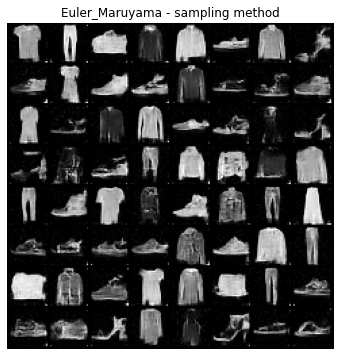

In [ ]:
display_sample(Euler_Maruyama_samples_1, "Euler_Maruyama - sampling method", sample_batch_size = 64)

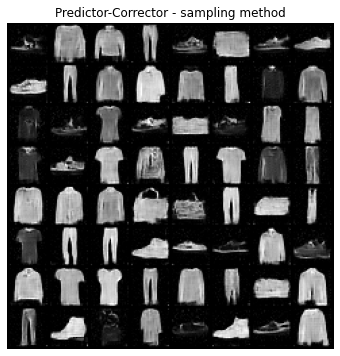

In [ ]:
display_sample(pc_samples_1, "Predictor-Corrector - sampling method", sample_batch_size = 64)

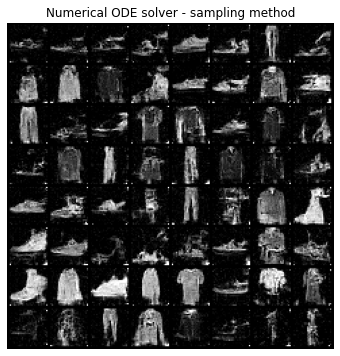

In [ ]:
display_sample(ode_samples_1, "Numerical ODE solver - sampling method", sample_batch_size = 64)

Overall The Euler-Mayama method and the predictor corrector method seems to have better results than the Numerical ODE method with this model. The blog highlited possible accuracy when there is not enough representation for certain zone of the distribution. Despite the SDE training this effect is still vissible for the numerical ode sampler.

**Here we use the three differents methods with the same initialisation x_1 :**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


  0%|          | 0/500 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


  0%|          | 0/500 [00:00<?, ?it/s]

Number of function evaluations: 320


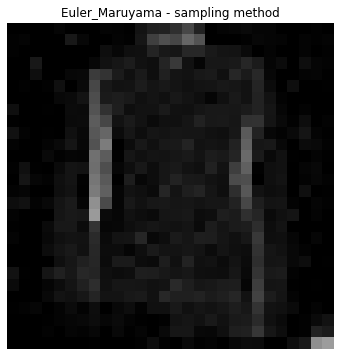

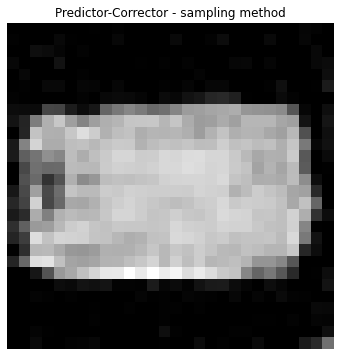

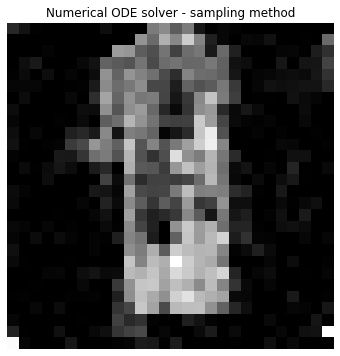

In [ ]:
t_1 = torch.ones(1, device=device)
trand_1 = torch.randn(1, 1, 28, 28, device=device)  #each sampling will use the same random time spliting
x_1 = trand_1*marginal_prob_std_1(t_1)[:, None, None, None]

Euler_Maruyama_mono = Euler_Maruyama_sampler(score_model_1, marginal_prob_std_1, diffusion_coeff_1, z = x_1, batch_size_euler = 1).clamp(0.0, 1.0)
pc_mono = pc_sampler(score_model_1, marginal_prob_std_1, diffusion_coeff_1, z = x_1, batch_size_pc = 1).clamp(0.0, 1.0)
ode_mono = ode_sampler(score_model_1, marginal_prob_std_1, diffusion_coeff_1, z = x_1, batch_size_ode = 1).clamp(0.0, 1.0)

display_sample(Euler_Maruyama_mono, "Euler_Maruyama - sampling method", sample_batch_size = 1)
display_sample(pc_mono, "Predictor-Corrector - sampling method", sample_batch_size = 1)
display_sample(ode_mono, "Numerical ODE solver - sampling method", sample_batch_size = 1)

We clearly see that same input and same scoring model produces differents outputs when using differetns sampling methods.

**Differences between models using the same sampling method Euler-Maruyama method.**

* Sampling method : Euler-Maruyama
* Models trained with SDE using : $g(t) = \sigma ^{t/10}$ | $g(t) = \sigma ^t$ | $g(t) = \sigma ^{3t}$

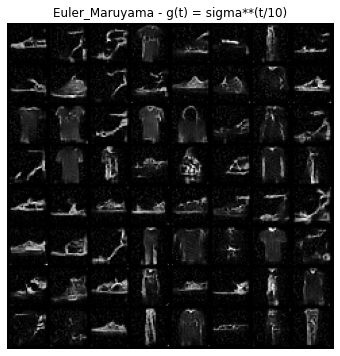

In [ ]:
display_sample(Euler_Maruyama_samples_0, "Euler_Maruyama - g(t) = sigma**(t/10)", sample_batch_size = 64)

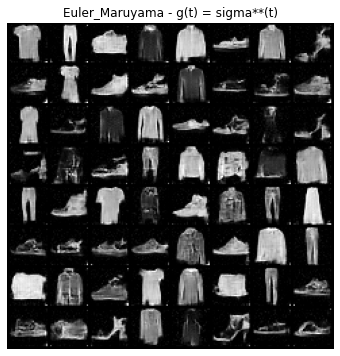

In [ ]:
display_sample(Euler_Maruyama_samples_1, "Euler_Maruyama - g(t) = sigma**(t)", sample_batch_size = 64)

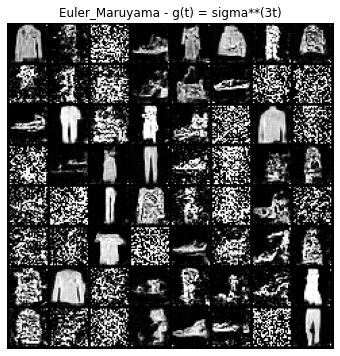

In [ ]:
display_sample(Euler_Maruyama_samples_3, "Euler_Maruyama - g(t) = sigma**(3t)", sample_batch_size = 64)

**This example expose this affirmation from the blog :**

"*How do we choose an appropriate noise scale for the perturbation process? Larger noise can obviously cover more low density regions for better score estimation, but it over-corrupts the data and alters it significantly from the original distribution. Smaller noise, on the other hand, causes less corruption of the original data distribution, but does not cover the low density regions as well as we would like.*"

**Here this the best diffusion function is the same that for the MNIST dataset, which seems logical regarding the similarities between the two datasets. Indeed the preliminary work regarding the pairwise distance of elements seems to be efficient**

# Conclusion

To conclude, we can already notice the impact of the diffusion function on the loss function. Indeed, the faster the diffusion function increases, the more the loss decreases. However we have seen that a low loss does not always imply a quality sampling. Thus we had to calibrate our diffusion function (by calculating the maximum distance between two objects of the marginal dataset) to have correct sampling results.

We also shown that for same initial noisy image and the same scoring model, differents sampling methods come up with completly different synthetic image. This expose that the dsitribution $p(x(0)|x(t=1))$ is completly random as expected.

## References

* [Yang Song notebook](https://colab.research.google.com/drive/120kYYBOVa1i0TD85RjlEkFjaWDxSFUx3?usp=sharing#scrollTo=GFuMaPov5HlV)
* [Score-Based Generative Modeling through Stochastic Differential Equations](https://openreview.net/forum?id=PxTIG12RRHS)
* [Explicative blog on score-based generative modeling](https://yang-song.github.io/blog/2021/score/)
* [U-net presentation paper](https://arxiv.org/abs/1505.04597)